# Introducción a las redes neuronales con ejemplos numéricos

------------------------------------


### Algunos tipos de redes neuronales
Fuente: https://www.asimovinstitute.org/neural-network-zoo/
<div>
    <img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png", width="500">
</div>

## 1. Construyamos una red neuronal configurable con keras

In [4]:
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

In [2]:
class neural_net:
    def __init__(self, X, Y, topology, epochs=50, lr=0.0001, bs=4, early_tol=100, scale=False):
        self.topology = topology
        self.epochs = epochs
        self.lr = lr
        self.bs = bs
        self.early_tol = early_tol
        self.scale = scale
    
        ntrain = int(0.8* len(X))
        indx = [ntrain]
        self.X_train, self.X_test = np.split(X, indx)
        self.Y_train, self.Y_test = np.split(Y, indx)
        
        if self.scale:
            self.scaler = StandardScaler()
            try:
                self.scaler.fit(X)
                self.X_train = self.scaler.transform(self.X_train)
                self.X_test = self.scaler.transform(self.X_test)
            except:
                self.scaler.fit(X.reshape(-1,1))
                self.X_train = self.scaler.transform(self.X_train.reshape(-1,1))
                self.X_test = self.scaler.transform(self.X_test.reshape(-1,1))

            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)
        
        self.model = self.model()
        self.model.summary()
        
    def model(self):
        # Red neuronal
        model = K.models.Sequential()
        # Hidden layers

        for i, nodes in enumerate(self.topology):
            if i == 0:
                model.add(K.layers.Dense(self.topology[1], input_dim=self.topology[0], activation='relu'))
            elif i < len(self.topology)-2:
                model.add(K.layers.Dense(self.topology[i+1], activation='relu'))
            else:
                model.add(K.layers.Dense(self.topology[i], activation='relu'))
        optimizer = K.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        return model                    
    
    def train(self):
        callbacks = [K.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                               min_delta=0.0,
                                               patience=self.early_tol,
                                               restore_best_weights=True)]
        print("Entrenando, por favor, espera...")
        self.history = self.model.fit(self.X_train,
                                      self.Y_train,
                                      validation_data=(self.X_test,
                                                       self.Y_test),
                                      epochs=self.epochs, batch_size=self.bs,
                                      callbacks=callbacks, verbose=0)
        print("¡Entrenamiento terminado!")
        return self.history
    
    def get_w_and_b(self, nlayer):
        weights, biases = self.model.layers[nlayer].get_weights()
        return weights, biases
    
    def predict(self, x):
        if type(x) == type([1]):
            x = np.array(x)
        if type(x) == type(1):
            x = np.array([x])
        if self.scale:
            try:
                x = self.scaler.transform(x)
            except:
                x = self.scaler.transform(x.reshape(-1,1))
        return self.model.predict(x)
        
    def plot(self):
        plt.plot(self.history.history['loss'], label='training set')
        plt.plot(self.history.history['val_loss'], label='validation set')
        mse = np.min(self.history.history['val_loss'])
        plt.title('MSE: {} Uncertainty: {}'.format(mse, np.sqrt(mse)))
        plt.ylabel('loss function')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        

## 2. Ejemplos numéricos

### 2.1 Ejemplo 1: Aprendiendo funciones

#### Analicemos si una red neuronal puede aprender las siguientes tres funciones:

* $line(x) = 2x+3$
* $quadratic(x) = x^2 +2$
* $quadtres(x_1,x_2,x_3) = x_1^2 + 2x_2 + x_3$

In [3]:
def line(x):
    return 2*x + 3 + 0.05 * np.random.rand()

def quadratic(x):
    return x**2 + 2 + 0.001 * np.random.rand()

def quadtres(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = x[i, 0]**2 + 2*x[i, 1] + x[i, 2]
    return y

In [4]:
# Descomentar función para generar datos
# fn = line
fn = quadratic
# fn = quadtres

# Seleccionar número de puntos para el dataset
npoints = 100

# Generar X
## para line y quadratic
X = np.random.rand(npoints)
## para quadtres
# X = np.random.rand(npoints, 3)

# Generar Y
Y = fn(X)

# Ver tabla de datos
## para line y quadratic
data =pd.DataFrame(zip(X,Y), columns=['x', 'y'])
## para quadtres
# data =pd.DataFrame(zip(X[:,0], X[:,1], X[:,2], Y), columns=['$x_1$', '$x_2$', '$x_3$', 'y'])
data.head(10)

,x,y
0,0.816347,2.666550
1,0.266427,2.071111
2,0.253359,2.064318
3,0.957180,2.916321
4,0.091266,2.008457
5,0.237289,2.056434
6,0.242728,2.059045
7,0.634832,2.403140
8,0.289295,2.083820
9,0.923894,2.853708


In [5]:
network = neural_net(X, Y, [1, 100, 100, 1], epochs=100, bs=16, lr=0.01, scale=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________


In [6]:
network.train()

Entrenando, por favor, espera...
¡Entrenamiento terminado!


In [7]:
w, b = network.get_w_and_b(nlayer=0)
print(len(w), len(b))
print(w)

1 100
[[ 0.09073548  0.03683569  0.1272345  -0.04530592 -0.08731974 -0.02017452
   0.13247125  0.22176552  0.13202915  0.19293717  0.0390545  -0.10581411
   0.17415795  0.10319219 -0.2268517  -0.17601317 -0.05653539 -0.08147119
   0.08443125 -0.13221471  0.18806064  0.12905279 -0.1846483   0.12742019
   0.08839188  0.2230798  -0.12403213 -0.18583491  0.00510015 -0.1835457
   0.12154972  0.07201198  0.11660336  0.19014804  0.24737735  0.11112522
  -0.14981431  0.04534094  0.03579356  0.23934421 -0.23521414 -0.07447726
  -0.12546861  0.24218294  0.08983645  0.05249953 -0.1877403   0.23828985
  -0.23187254  0.05759685  0.08209809 -0.13947132 -0.06188912  0.2019935
  -0.06878823 -0.17782019 -0.17649971  0.08163596  0.14869002  0.12687767
   0.14051794  0.23627402  0.11273591 -0.22990827  0.16370364 -0.0058809
   0.05123386 -0.19738969 -0.11770015  0.12143328  0.24779686  0.10106406
   0.21692874  0.00302593 -0.07346775  0.04661466 -0.13062678  0.01131258
  -0.11133101 -0.09698294  0.139472

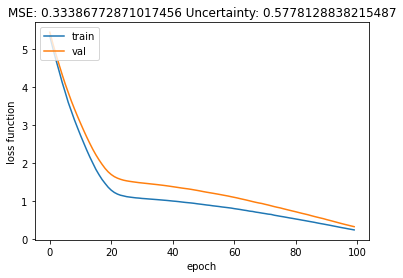

In [8]:
network.plot()

In [9]:
# new_vector = np.array([0.7, 0.5, 0.6]).reshape(1,3)
new_vector = np.array([0.7])
prediction = network.predict(new_vector)


print("Valor real: {}".format(float(fn(new_vector))))
print("Predicción: {}".format(float(prediction)))

Valor real: 2.4907941763050516
Predicción: 1.6429128646850586


In [10]:
from time import time
from scipy import integrate

### 2.2 Ejemplo 2: Ahorrando tiempo de cómputo

#### Experimento con alguna integral doble arbitraria con parámetros a, b:

$\int^1_0 \int^1_0 \sqrt{x^2 + y^2+ a^2} + b\frac{xy}{2}dx dy$

#### Analicemos si una red neuronal puede aprender a calcular esta integral y ahorrar tiempo cuando se requiere evaluar múltiples veces.

In [11]:
def f(x, y, a, b):
    return np.sqrt(x**2 + y**2 + a**2) + b*0.5*x*y 

t1 = time()
i = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1, args=([0.1, 0.2]))
print(i[0])
print("Tiempo: {:.4f} segundos".format(time()-t1))

0.7985035067551794
Tiempo: 0.0009 segundos


In [12]:
npoints = 10000
ab_points = np.random.rand(npoints, 2)
integrals = np.zeros(npoints)

t1 = time()
for i in range(npoints):
    a = ab_points[i, 0]
    b = ab_points[i, 1]
    integ, _ = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1, args=([a, b]))
    integrals[i] = integ
t = time()-t1

print("Tiempo: {:.5f} segundos".format(t))
h = pd.DataFrame(zip(ab_points[:,0], ab_points[:,1], integrals), columns=['a', 'b', 'integral'])
h.head()

Tiempo: 10.49775 segundos


,a,b,integral
0,0.908033,0.864185,1.317055
1,0.308708,0.029195,0.839021
2,0.961858,0.238569,1.280551
3,0.857692,0.284165,1.206383
4,0.315461,0.316511,0.877760


In [13]:
network = neural_net(ab_points, integrals, [2, 100, 1], epochs=100, bs=16, lr=0.01, scale=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________


In [14]:
network.train()


Entrenando, por favor, espera...
¡Entrenamiento terminado!


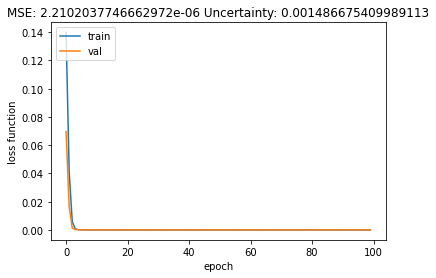

In [15]:
network.plot()

In [16]:
npoints = 10000
ab_points = np.random.rand(npoints, 2)
integrals = np.zeros(npoints)

t1 = time()
predictions = network.predict(ab_points)
t = time()-t1
print("Tiempo: {:.5f} segundos".format(t))
print(np.shape(predictions))
h = pd.DataFrame(zip(ab_points[:,0], ab_points[:,1], predictions), columns=['a', 'b', 'integral'])
h.head()

Tiempo: 0.10767 segundos
(10000, 1)


,a,b,integral
0,0.025018,0.171491,[1.0060536]
1,0.608376,0.945901,[1.1414541]
2,0.217536,0.591532,[1.0534743]
3,0.537712,0.149848,[1.0977129]
4,0.471587,0.917434,[1.1144915]


In [17]:
# Probemos un valor al azar
a = 0.751548
b = 0.458467
integ, _ = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1, args=([a, b]))
print(integ)

1.150683917251989


### Ejercicio 5 (opcional)

Intenta con otra función. Genera datos sintéticos a partir de su expresión analítica. Entrena la red neuronal con estos datos. Compara tiempos y qué tan parecidas son las predicciones de la red neuronal a los valores reales.

#### Este mecanismo se puede utilizar para aprender la función de likelihood, la cual se evalúa miles de veces, dentro de un proceso de inferencia Bayesiana.
<div>
    <img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/ann.png" width="500">
</div>

<div>
    <img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/uamresults.png" width="500">
</div>
              
              

                                                                                                                                                                                                                         
#### Referencia: [DOI: 10.1088/1742-6596/1723/1/012022](https://iopscience.iop.org/article/10.1088/1742-6596/1723/1/012022)           

### 2. 3: Modelemos unos datos cosmológicos


#### Utilicemos la compilación Union 2.1 para ver si la red neuronal puede  modelar sus datos y sus errores.

#### Idea general:
<div>
<img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/annHz.png" width="300"/>
</div>

#### Referencia: [arXiv:2104.00595](https://arxiv.org/abs/2104.00595)


In [66]:
file = 'https://raw.githubusercontent.com/igomezv/MACS_2021_neural_networks/main/data/Union2.1_DL.txt'
data =pd.read_csv(file, sep=' ', names=['z','$D_L(z)$','error'])
data.head()

,z,$D_L(z)$,error
0,0.0150,61.659500,5.111145
1,0.0150,66.374307,6.418965
2,0.0150,67.920363,5.004557
3,0.0150,75.162289,7.614973
4,0.0151,80.537844,7.788700


<ErrorbarContainer object of 3 artists>

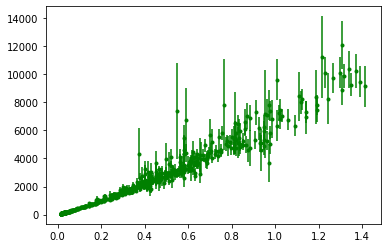

In [67]:
plt.errorbar(data['z'], data['$D_L(z)$'], yerr = data['error'], c='g', fmt='.')

In [62]:
X = data['z'].values
Y = data[['$D_L(z)$', 'error']].values
network = neural_net(X, Y, topology=[1, 50, 50, 2], scale=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_48 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_49 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 102       
Total params: 5,302
Trainable params: 5,302
Non-trainable params: 0
_________________________________________________________________


Entrenando, por favor, espera...
¡Entrenamiento terminado!


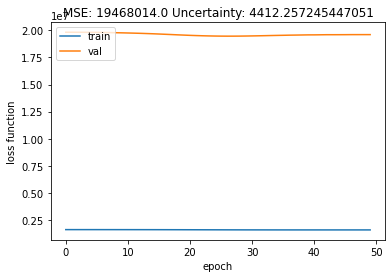

In [63]:
network.train()
network.plot()

<ErrorbarContainer object of 3 artists>

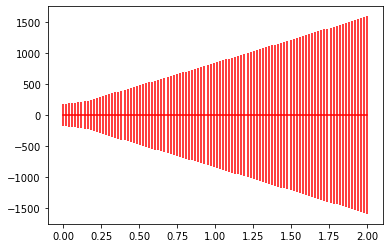

In [64]:
fake_z = np.linspace(0, 2, 100)
fake_dl = network.predict(fake_z)
plt.errorbar(fake_z, fake_dl[:,0], yerr=fake_dl[:, 1], c='r')
# plt.errorbar(data['z'], data['$D_L(z)$'], yerr = data['error'], c='g', fmt='.')

### Debido a que la red neuronal no está bien ajustada el resultado no es preciso. 

### -> Ejercicio 6 (opcional):

Utilizar diferentes configuraciones de numeros de paredes y nodos para que el modelo de la red neuronal se parezca más a los datos reales.


## 4.4 Aproximando ecuaciones diferenciales

In [48]:
def RHS(Omega_i, lna, gamma=0):
    #x, y, z, H = Omega_i
    x, y, z = Omega_i
    pi = 3*x + 4*y
    #return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(t,Om):
    #t,Or,Om,Ol=X
    Or=0.0001
    Ol=1-Or-Om
    H0 = 70.
    y0 = [Om, Or, Ol]
    result = odeint(RHS, y0, t)
    return result

In [72]:
from scipy.integrate import odeint

O_m=np.arange(0.1,1.1,0.01)
t=np.linspace(0,-12,100)
Y0=[]
for i in O_m:
    Y0.extend(EDO(t,i))
Y0=np.array(Y0)

X0=[]
for Om in O_m:
    for T in t:
        X0.append([T,Om])
X0=np.array(X0)
#Dos paredes ocultas
nodos=100
split_size=0.8
learning_rate=0.001
epocas=100
np.shape(X0), np.shape(Y0)

((10000, 2), (10000, 3))

In [73]:
network = neural_net(X0, Y0, topology=[2, 100, 100, 3], lr=0.001, epochs=100)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_54 (Dense)             (None, 3)                 303       
Total params: 20,803
Trainable params: 20,803
Non-trainable params: 0
_________________________________________________________________


Entrenando, por favor, espera...
¡Entrenamiento terminado!


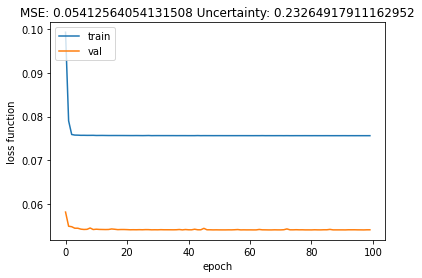

In [74]:
network.train()
network.plot()

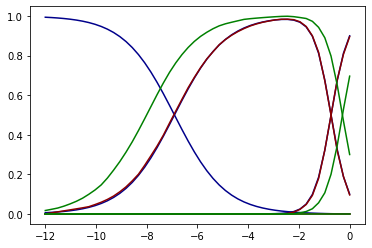

In [75]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]

for z in Z: dom.append([z,0.1]) 
A=network.predict(dom)

for z in Z: dom2.append([z,0.3]) 
B=network.predict(dom2)

for z in Z: dom3.append([z,0.9]) 
C=network.predict(dom3)

plt.plot(Z,EDO(Z, 0.1),color='darkblue')
plt.plot(Z,A,color='darkred')
plt.plot(Z,B,color='green')
# plt.plot(Z,C,color='

# Nota: Las redes neuronales pueden hacer tareas de regresión o clasificación.

### -> Ejercicio 7 (Opcional)

Utilizar los datos completos del SDSS utilizados en la Notebook 1, para clasificar galaxias, cuásares y estrellas. 

<AxesSubplot:xlabel='ra', ylabel='redshift'>

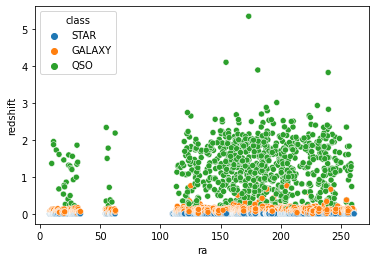

In [5]:
data_dr14 = pd.read_csv('/home/cosmocicatais/Documents/github/MACS_2021_neural_networks/data/Skyserver_SQL2_27_2018 6_51_39 PM.csv')
sns.scatterplot(x="ra", y="redshift", data=data_dr14, hue="class")

In [6]:
data_dr14.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


----------------------

## Comentarios

- Para problemas numéricos hay que ser muy cuidadosos con la elección de la arquitectura de la red, sus errores y conocer los datos de antemano.

- El ajuste de hiperpárametros y el entrenamiento de la red pueden ser procesos muy lentos.

- Para ciertos problemas no-lineales las redes neuronales pueden generar un modelo aceptable un buen modelo basado en los datos.

## Referencias:

- https://keras.io/

- https://igomezv.github.io/2020-10-09-intro-neural/

- Gómez-Vargas, I., Vázquez, J. A., Esquivel, R. M., & García-Salcedo, R. (2021). Cosmological Reconstructions with Artificial Neural Networks. arXiv preprint arXiv:2104.00595.

- Gómez-Vargas, I., Esquivel, R. M., García-Salcedo, R., & Vázquez, J. A. (2021). Neural network within a Bayesian inference framework. In Journal of Physics: Conference Series (Vol. 1723, No. 1, p. 012022). IOP Publishing.

- Vázquez, J. A., Esquivel, R. M., & Gómez-Vargas, I. (2021). Cosmologıa observacional con Redes Neuronales Artificiales. Esta edición fue preparada por el Instituto de Física y el Instituto de Ciencias Físicas de la UNAM., 89.
